In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from keras.initializers import GlorotUniform, HeUniform, HeNormal
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
!pip install tab2img -q # q for quiet
from tab2img.converter import Tab2Img
seed = 314159
np.random.seed(seed)
tf.random.set_seed(seed)

ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.datasets import cifar10, mnist
from keras.optimizers.legacy import SGD, Adam
from keras.utils import to_categorical
from keras.backend import image_data_format
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Reshape
from keras.layers import Dense, Dropout, BatchNormalization


import matplotlib.pyplot as plt
import numpy as np
import copy

import csv
import random
import time

# Importing necessary libraries for preprocessing and modeling
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout


In [3]:
train_path = 'C:/Users/Mo-gh/Desktop/New folder/KDDTrain+.txt'
test_path = 'C:/Users/Mo-gh/Desktop/New folder/KDDTest+.txt'

In [4]:
def attack(row):
    if row['attack'] == 'normal':
        return 'normal'
    elif row['attack'] in ['port-Sweep', 'ip-Sweep', 'nmap', 'satan', 'saint', 'mscan']:
        return 'Probing'
    elif row['attack'] in ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back', 'apache2',
                          'udpstorm', 'processtable', ',mail-Bomb']:
        return 'Dos'
    elif row['attack'] in ['buffer-Overflow', 'load-Module', 'perl', 'rootkit', 'xterm',
                          'ps', 'sqlattack']:
        return 'U2R'
    else:
        return 'R2L'

In [5]:
Train_data = pd.read_csv(train_path)
Test_data = pd.read_csv(test_path)

# Drop the unnecessary columns
Train_data.drop('20', axis=1, inplace=True)
Test_data.drop('21', axis=1, inplace=True)

# Renaming columns
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
            'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
            'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
            'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
            'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
            'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
            'dst_host_srv_rerror_rate','attack'])

Train_data.columns = columns
Test_data.columns = columns

Train_data.drop('num_outbound_cmds', axis=1, inplace=True)
Test_data.drop('num_outbound_cmds', axis=1, inplace=True)

Train_data['attack'] = Train_data.apply(attack, axis=1)
Test_data['attack'] = Test_data.apply(attack, axis=1)

# Label encoding categorical features
protocol_type_le = LabelEncoder()
service_le = LabelEncoder()
flag_le = LabelEncoder()

Train_data['protocol_type'] = protocol_type_le.fit_transform(Train_data['protocol_type'])
Train_data['service'] = service_le.fit_transform(Train_data['service'])
Train_data['flag'] = flag_le.fit_transform(Train_data['flag'])

Test_data['protocol_type'] = protocol_type_le.transform(Test_data['protocol_type'])
Test_data['service'] = service_le.transform(Test_data['service'])
Test_data['flag'] = flag_le.transform(Test_data['flag'])

# One-hot encoding the target variable
Train_data = pd.get_dummies(Train_data, columns=['attack'])
Test_data = pd.get_dummies(Test_data, columns=['attack'])

# Align Test_data columns to Train_data columns (to ensure same number of columns)
Test_data = Test_data.reindex(columns=Train_data.columns, fill_value=0)

# Selecting important features
ImportantFeatures = Train_data.columns[0:40]
x_train = Train_data[ImportantFeatures].values
y_train = Train_data[['attack_normal', 'attack_Probing', 'attack_Dos', 'attack_U2R', 'attack_R2L']].values.astype(int)

x_test = Test_data[ImportantFeatures].values
y_test = Test_data[['attack_normal', 'attack_Probing', 'attack_Dos', 'attack_U2R', 'attack_R2L']].values.astype(int)

# Verify the label encoding
print("Sample y_train before reshaping and conversion:")
print(y_train[:5])


# Verify the reshaping
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Sample y_train before reshaping and conversion:
[[1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]]
Shape of x_train: (125972, 40)
Shape of x_test: (22543, 40)


In [6]:
unique_elements, counts = np.unique(y_train, axis=0, return_counts=True)
print("Unique elements:")
print(unique_elements)
print("\nCounts:")
print(counts)

Unique elements:
[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]]

Counts:
[ 7564    13 45927  5126 67342]


In [7]:
# Set seed
seed_pi = 314159

# Set numpy seed
np.random.seed(seed_pi)
# Set the seed for TensorFlow
tf.random.set_seed(seed_pi)

In [8]:
def extractAllSets(X,y,p_train,p_val,p_test,random_state=seed_pi,shuffle=True):
    # The initial train-test split produces X_train and y_train
    # Two additional sets are created X_temp and y_temp, that will produce the rest of the sets
    X_train, X_temp, y_train, y_temp = train_test_split(X,y, stratify=y,
        test_size=(1.0 - p_train), random_state=random_state, shuffle=shuffle)
                                                                        # Enable/desable shuffling
    # Note that by applying the stratify condition we ensure homogeneous distribution
    # of chareacteristics in targets

    # Parameter fraction describes the relevant size of the test size
    fraction = p_test / (p_val + p_test)
    X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,stratify=y_temp,
        test_size=fraction, random_state=random_state, shuffle=shuffle) # Enable/desable shuffling
    # Note that we use the same random_state twice for reproducibility

    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = extractAllSets(x_train, y_train, 0.65, 0.1, 0.25)

# Organize all sets in list format
original_data = [X_train, X_val, X_test, y_train, y_val, y_test]

In [10]:
# Initialize QuantileTransformer with uniform distribution
quantile_transformer = QuantileTransformer(n_quantiles=10**3, output_distribution='normal')

# Fit and transform the training data
X_train_transformed = quantile_transformer.fit_transform(X_train)

# Transform the validation and test data using the same transformer
X_val_transformed  = quantile_transformer.transform(X_val)
X_test_transformed = quantile_transformer.transform(X_test)

# Arrange transformed data as a list
scaled_data = [X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test]

In [11]:
Y_train = np.argmax(y_train, axis=1)
Y_test_test = np.argmax(y_test, axis=1)

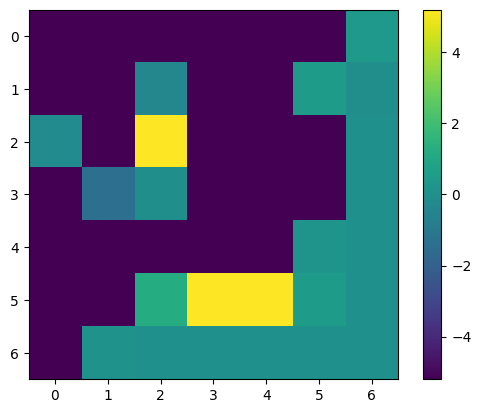

In [12]:
# Define the Tab2Img model
model_tab2img = Tab2Img()

""" In this stage, every sample in the data becomes a (9x9) numpy array. """
# Convert training data
X_train_images = model_tab2img.fit_transform(X_train_transformed, Y_train)

# Convert validation and test data (using the fitted model)
X_val_images  = model_tab2img.transform(X_val_transformed)
X_test_images = model_tab2img.transform(X_test_transformed)

""" In this stage, every array in the data becomes a (9x9x1) greyscale image. """
# Greyscale Transformation - Reshape the image data for CNN input
X_train_images = X_train_images.reshape(-1, 7, 7, 1)
X_val_images   = X_val_images.reshape(  -1, 7, 7, 1)
X_test_images  = X_test_images.reshape( -1, 7, 7, 1)

# Visualize an example
plt.imshow(X_train_images[0])
plt.colorbar()
plt.show()

In [13]:
import numpy as np
X_train_images = np.array(X_train_images)
X_test_images = np.array(X_test_images)
Y_train = np.array(Y_train)
Y_test_test = np.array(Y_test_test)

In [14]:
X_train_images.shape, X_test_images.shape, Y_train.shape, Y_test_test.shape

((81881, 7, 7, 1), (31494, 7, 7, 1), (81881,), (31494,))

In [15]:
import random
import numpy as np
import numpy.linalg as lina
from scipy.optimize import linprog
import cvxopt as opt

def subsets_Size_NElem(s, nElems):
     res = []
     for i in range(1 << s):
        bin_string = list(format(i, '0'+str(s)+'b'))
        vec = [float(x) for x in bin_string]
        if (sum(vec)==nElems):
             res.append(vec)
     return(res)


def multLL(lista, listb):
  return [a*b for a,b in zip(lista,listb)]

def create_lhs_eqCol (nClass, nVars, nDev, vecVars):
   res = []
   for i in range(0,nClass):
      constrCol = [0.0]*nVars
      for j in range(0,nDev):
         pos = i + j*nClass
         constrCol[pos]=1.0
      restrictedCol = multLL(constrCol, vecVars)
      len(constrCol)
      res.append(restrictedCol) ## constrCol)
   return res

def create_lhs_eqCol_weights (nClass, nVars, nDev, vecVars, vecWeights):
   res = []
   for i in range(0,nClass):
      constrCol = [0.0]*nVars
      for j in range(0,nDev):
         pos = i + j*nClass
         constrCol[pos]=vecWeights[j]
      restrictedCol = multLL(constrCol, vecVars)
      len(constrCol)
      res.append(restrictedCol)
   return res

def create_lhs_eqRow (nClass, nVars, nDev, vecVars):
   res = []
   for i in range(0,nDev):
      constrRow = [0.0]*nVars
      for j in range(0,nClass):
         pos = i*nClass + j
         constrRow[pos]=1.0
      restrictedRow = multLL(constrRow, vecVars)
      len(constrRow)
      res.append(restrictedRow)
   return res

def matrMN (m, n):

     mt = np.zeros((m,n))
     for i in range(0,m):
          mt[i][i]=-1.0
     return(mt)

def sumColsGetCol (mt):
     """Matrix given as list of rows"""
     return(map(sum,mt))

def sumRowsGetRow (mt):
     """Matrix given as list of rows"""
     return(sumColsGetCol(np.transpose(mt)))

def printMat (mt):
     for i in range(0,len(mt)):
          printRow(mt[i])

def printRow (rw):
     print("[",end='')
     for i in range(0,len(rw)):
          print(rw[i],' ',end='')
     print("]")

def makeEquationsForZeros (lwZeros):
     return (list(map(lambda pos: [0]*(pos)+[1]+[0]*(len(lwZeros)-pos-1),
                      np.where(lwZeros==0)[0])))

def create_solution_weights (numInstancesClass, classesPerDevice, nCopies, vecWeights=[]):
    totalNRecords = sum(numInstancesClass)     # number of records
    nClass = len(numInstancesClass)            # number of classes
    oneSetofDevices = subsets_Size_NElem(nClass, classesPerDevice)
    lol = oneSetofDevices*nCopies
    nDev = nCopies * len(oneSetofDevices)      # number of devices
    nVars = nClass * nDev                      # number of variables
    #
    sumCols = list(map(lambda x:x*1/totalNRecords,numInstancesClass))
    #
    vecVars = list(np.array(lol).flat)
    if vecWeights==[]:
         vecWeights=[1/nDev]*nDev
    #
    #
    ### Constraints for the columns, left side
    lhs_eqCol = create_lhs_eqCol_weights (nClass, nVars, nDev, vecVars, vecWeights)
    ### Constraints for the columns, right side. This is given
    rhs_eqCol = sumCols  ## numInstancesClass
    #
    ### Constraints for the rows, left side
    lhs_eqRow = create_lhs_eqRow (nClass, nVars, nDev, vecVars)
    ### Constraints for the rows, right side
    rhs_eqRow = [1.0]*nDev
    #
    lhs_probZero  = makeEquationsForZeros(np.array(vecVars))
    rhs_probZero = [0]*len(lhs_probZero)
    neq_probZero = len(rhs_probZero)
    #
    # All equality constraints.
    # Probabilities equal to zero, before the others as we may delete an equality later.
    #
    lp_lhs_eq = lhs_probZero + lhs_eqCol + lhs_eqRow
    lp_rhs_eq = rhs_probZero + rhs_eqCol + rhs_eqRow
    nConstraints = neq_probZero + nDev + nClass        # Probs == 0, for rows, eq. for columns
    rankAllMat = lina.matrix_rank(lp_lhs_eq)
    newRank = lina.matrix_rank(lp_lhs_eq[0:len(lp_lhs_eq)-1])
    # print("Rank matrix lp_lhs_eq, dim (and rank if full rank) = "+str(len(lp_lhs_eq)))
    # print(str(rankAllMat))
    # print("Rank of matrix lp_lhs_eq without the last row=")
    # print("newRank"+str(newRank))
    if (len(lp_lhs_eq) != rankAllMat) and (newRank == (len(lp_lhs_eq)-1)):
         print("CORRECT RANK")
         lp_lhs_eq = lp_lhs_eq[0:len(lp_lhs_eq)-1]
         lp_rhs_eq = lp_rhs_eq[0:len(lp_rhs_eq)-1]
         nConstraints = nConstraints-1
    #
    mA=opt.matrix(np.array(lp_lhs_eq))
    mb=opt.matrix(lp_rhs_eq, (nConstraints, 1))
    #
    # The objective function  x'Qx + L'x
    #
    mQ = opt.matrix(np.identity(nVars))      # ecsQ = matrix(np.identity(18))
    # L = (-1, ..., -1)
    alphaRandomVector = np.random.uniform(0,1,nVars)
    mL = opt.matrix(-1*2*alphaRandomVector,(nVars,1))
    #
    # print("Alpha Random Vector")
    # print(alphaRandomVector)

    mG = opt.matrix((np.identity(nVars))*-1)   # ecsG = matrix((np.identity(18))*-1)
    # h = (0, ..., 0)
    mh = opt.matrix([0.0]*(nVars),(nVars,1))   # ecsH = matrix([0.0]*18,(18,1))
#
    sol = opt.solvers.qp(mQ, mL, G=mG, h=mh, A=mA, b=mb)
    vPDev = multLL(sol['x'], vecVars) ## Probabilities Devices
    mtPDev = np.array(vPDev).reshape((nDev,nClass))
    ##
    mtNRecDev = list(map(lambda l,e: list(map(lambda el: el*e*totalNRecords, l)),
                         mtPDev, vecWeights))
    # return sol
    return(mtNRecDev)


def create_assignment (y, mtDevClas2Records):

     nDev = len(mtDevClas2Records)
     record2Dev = [0]*len(y)
     for classPos in range(0,len(set(y))):
          className = list(set(y))[classPos]
          ##
          vDev2Records  = list(map(lambda x:x[classPos], mtDevClas2Records))
          vDev2Probs    = list(map(lambda x:x/sum(vDev2Records), vDev2Records))
          recordsInClass= np.where(y==className)[0]
          vDevices = np.random.choice(range(1,nDev+1),
                                      size=len(recordsInClass),replace=True,p=vDev2Probs)
          for i in range(0,len(recordsInClass)):
               indexRecord = recordsInClass[i]
               device=vDevices[i]
               record2Dev[indexRecord]=device
     return(record2Dev)

In [15]:
from keras.layers import Dense, GRU, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.regularizers import l2

# input_shape = (9,9,1)
num_classes = 5
class Model:
    def __init__(self, loss, optimizer, num_classes):
        self.loss = loss
        self.optimizer = optimizer
        self.num_classes = num_classes

    def fl_paper_model(self,train_shape):

          conv_initializer   = HeNormal(seed=seed_pi)
          dense_initializer  = HeUniform(seed=seed_pi)
          output_initializer = GlorotUniform(seed=seed_pi)
          mlp = Sequential([
          Input(shape=(7, 7, 1)),

          Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=conv_initializer),
          MaxPooling2D(pool_size=(2, 2)),
          Flatten(),
          Dense(128, activation='relu', kernel_initializer=dense_initializer),
          BatchNormalization(),
          Dropout(.01),
        #   Dense(64, activation='relu', kernel_initializer=dense_initializer),

          Dense(num_classes, activation='softmax', kernel_initializer=output_initializer)
      ])
          mlp.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
          return mlp

Shape of a single data point: (7,)
CORRECT RANK
     pcost       dcost       gap    pres   dres
 0: -4.3051e+01 -9.6143e+01  6e+02  2e+01  2e+00
 1: -3.7187e+01 -7.0702e+01  8e+01  2e+00  2e-01
 2: -3.5340e+01 -4.2195e+01  1e+01  1e-01  1e-02
 3: -3.6293e+01 -3.7774e+01  2e+00  2e-02  2e-03
 4: -3.6755e+01 -3.7002e+01  3e-01  3e-03  2e-04
 5: -3.6858e+01 -3.6878e+01  2e-02  1e-04  1e-05
 6: -3.6866e+01 -3.6873e+01  7e-03  6e-06  5e-07
 7: -3.6869e+01 -3.6869e+01  4e-04  4e-07  3e-08
 8: -3.6869e+01 -3.6869e+01  9e-06  6e-09  5e-10
Optimal solution found.
Client 1:
{0: 4771, 1: 715, 2: 2767}
Client 2:
{1: 641, 2: 7350, 4: 292}
Client 3:
{0: 5013, 2: 2840, 4: 420}
Client 4:
{0: 6692, 1: 337, 3: 8, 4: 1052}
Client 5:
{0: 4580, 1: 193, 2: 3285, 4: 171}
Client 6:
{0: 3816, 2: 4146}
Client 7:
{1: 722, 2: 5325, 4: 2118}
Client 8:
{0: 7731, 2: 638}
Client 9:
{0: 7036, 1: 611, 4: 408}
Client 10:
{0: 4133, 1: 113, 2: 3501, 4: 456}
particle 1/10 fitting
Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 35m

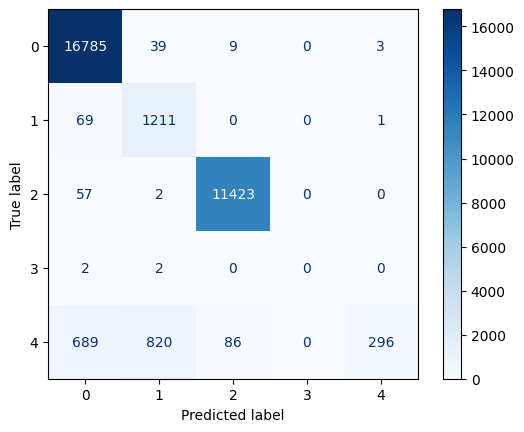

In [27]:
from tensorflow.keras.optimizers import Adam, SGD
NUMOFCLIENTS = 10 # number of clients (particles)
EPOCHS = 30  # number of total iterations
CLIENT_EPOCHS = 5 # number of each client's iterations
BATCH_SIZE = 256 # Size of batches to train on
ACC = 0.5
LOCAL_ACC = 0.9
GLOBAL_ACC = 1.4
DROP_RATE = 0
# Model configuration
# LOSS = 'binary_crossentropy'
LOSS = 'sparse_categorical_crossentropy'
NUMOFCLASSES = 5
lr = 0.0001
# lr = 0.001
OPTIMIZER = Adam(learning_rate=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_10Clients_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = Model(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

def client_data_config(X_train_images, Y_train, num_clients):

    # Parameters
    num_clients = 10
    classes_per_device = 4  # Adjust based on your dataset's characteristics
    nCopies = 8

    # Calculate the number of instances per class
    # numInstancesClass = list(map(lambda e: np.count_nonzero(y == e), set(Y_train)))
    numInstancesClass = list(map(lambda e: np.count_nonzero(Y_train == e), set(Y_train))) # Use Y_train instead of y
    # numInstancesClass = list(map(lambda e: np.count_nonzero(Y_train == e), set(tuple(row) for row in Y_train))) # Use Y_train instead of y



    # Generate the solution weights
    mtDevClas2Records = create_solution_weights(numInstancesClass, classes_per_device, nCopies)

    # Assign the records to clients, ensuring device numbers are within the valid range
    rec2dev = create_assignment(Y_train, mtDevClas2Records)
    rec2dev = [i % num_clients + 1 for i in rec2dev]  # Map device numbers to the range [1, num_clients]

    # Split the data based on device assignments
    client_data = {i: {'X_train_images': [], 'Y_train': []} for i in range(1, num_clients + 1)}
    for idx, device in enumerate(rec2dev):
        # Use .iloc with the index to access rows of X_train
        client_data[device]['X_train_images'].append(X_train_images[idx])
        client_data[device]['Y_train'].append(Y_train[idx])
    # Convert lists to numpy arrays
    for device in client_data:
        client_data[device]['X_train_images'] = np.array(client_data[device]['X_train_images'])
        client_data[device]['Y_train'] = np.array(client_data[device]['Y_train'])

    # client_data now contains the non-i.i.d. distributed data for each client

    for device, data in client_data.items():
        unique, counts = np.unique(data['Y_train'], return_counts=True)
        print(f"Client {device}:")
        print(dict(zip(unique, counts)))

    return client_data
class particle():
    def __init__(self, particle_num, client, x_train, y_train):
        # for check particle id
        self.particle_id = particle_num

        # particle model init
        self.particle_model = client

        # best model init
        self.local_best_model = client
        self.global_best_model = client

        # best score init
        self.local_best_score = 0.0
        self.global_best_score = 0.0

        self.x = x_train
        self.y = y_train

        # acc = acceleration
        self.parm = {'acc':ACC, 'local_acc':LOCAL_ACC, 'global_acc':GLOBAL_ACC}

        # velocities init
        self.velocities = [None] * len(client.get_weights())
        for i, layer in enumerate(client.get_weights()):
            self.velocities[i] = np.random.rand(*layer.shape) / 5 - 0.10

    def train_particle(self):
        print("particle {}/{} fitting".format(self.particle_id+1, NUMOFCLIENTS))

        # set each epoch's weight
        step_model = self.particle_model
        step_weight = step_model.get_weights()

        # new_velocities = [None] * len(step_weight)
        new_weight = [None] * len(step_weight)
        local_rand, global_rand = random.random(), random.random()

        # PSO algorithm applied to weights
        for index, layer in enumerate(step_weight):
            new_v = self.parm['acc'] * self.velocities[index]
            new_v = new_v + self.parm['local_acc'] * local_rand * (self.local_best_model.get_weights()[index] - layer)
            new_v = new_v + self.parm['global_acc'] * global_rand * (self.global_best_model.get_weights()[index] - layer)
            self.velocities[index] = new_v
            new_weight[index] = step_weight[index] + self.velocities[index]

        optimizer = Adam(learning_rate=lr)
        step_model.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])

        step_model.set_weights(new_weight)

        # Recreate the optimizer to avoid the error

        # 4.2 - Early Stopping, Learning Rate Scheduler and Compiling
        # save_model_path = 'checkpoint/checkpoint_particle_{}.weights.h5'.format(self.particle_id)
        save_model_path = 'checkpoint_1/checkpoint_particle_{}.weights.h5'.format(self.particle_id)

        mc = ModelCheckpoint(filepath=save_model_path,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            save_weights_only=True)

        early_stopping = EarlyStopping(
            monitor='accuracy',
            patience=10,
            verbose=1,
            restore_best_weights=True)

        reduce_lr = ReduceLROnPlateau(
            monitor='accuracy',
            patience=5,
            min_lr=1e-07,
            verbose=1,
            factor=0.1)

        hist = step_model.fit(x=self.x, y=self.y,
                              epochs=CLIENT_EPOCHS,
                              batch_size=BATCH_SIZE,
                              verbose=1,
                              validation_split=0.1,
                              callbacks=[mc])

        train_score_loss = hist.history['val_loss'][-1]

        step_model.load_weights(save_model_path)
        self.particle_model = step_model

        if self.global_best_score >= train_score_loss:
            self.local_best_model = step_model

        return self.particle_id, train_score_loss

    def update_global_model(self, global_best_model, global_best_score):
        if self.local_best_score < global_best_score:
            self.global_best_model = global_best_model
            self.global_best_score = global_best_score

    def resp_best_model(self, gid):
        if self.particle_id == gid:
            return self.particle_model


def get_best_score_by_loss(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 100000
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score > result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]


def get_best_score_by_acc(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 0
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score < result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]

if __name__ == "__main__":

    x_train = X_train_images
    y_train = Y_train
    x_test = X_test_images
    y_test = Y_test_test

    x_test = np.array(x_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)


    train_data_shape = (x_train[0].shape[1],)
    print("Shape of a single data point:", train_data_shape)
    client_data = client_data_config(x_train, y_train, NUMOFCLIENTS)

    server_model = init_model(train_data_shape=train_data_shape)
    # print(server_model.summary())

    pso_model = []
    for i in range(NUMOFCLIENTS):
        # pso_model.append(particle(particle_num=i, client=init_model(train_data_shape = x_train[0].shape[1]), x_train=client_data[i][0], y_train=client_data[i][1]))
        pso_model.append(particle(particle_num=i, client=init_model(train_data_shape = x_train[0].shape[1]), x_train=client_data[i+1]['X_train_images'], y_train=client_data[i+1]['Y_train']))


    server_evaluate_acc = []
    global_best_model = None
    global_best_score = 0.0

    for epoch in range(EPOCHS):
        server_result = []
        start = time.time()

        for client in pso_model:
            if epoch != 0:
                client.update_global_model(server_model, global_best_score)

            pid, train_score = client.train_particle()
            rand = random.randint(0, 99)

            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_result.append([pid, train_score])

        gid, global_best_score = get_best_score_by_loss(server_result)
        for client in pso_model:
            if client.resp_best_model(gid) != None:
                global_best_model = client.resp_best_model(gid)

        server_model = global_best_model

        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedPSO_TORA_NSLKDD", server_evaluate_acc)


import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(server_model.predict(x_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUMOFCLASSES))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUMOFCLASSES)])
disp.plot(cmap=plt.cm.Blues)
plt.show()
'''Confusion Matrix TORA NSLKDD FedPSO:
[[16785    39     9     0     3]
 [   69  1211     0     0     1]
 [   57     2 11423     0     0]
 [    2     2     0     0     0]
 [  689   820    86     0   296]]'''

In [20]:
# Global configuration
from tensorflow.keras.optimizers import Adam, SGD

NUMOFCLIENTS = 10 # number of clients (particles)
EPOCHS = 30  # number of total iterations
CLIENT_EPOCHS = 5 # number of each client's iterations
BATCH_SIZE = 256 # Size of batches to train on
ACC = 0.5
LOCAL_ACC = 0.9
GLOBAL_ACC = 1.4
DROP_RATE = 0
SELECT_CLIENTS = 1
# Model configuration
# LOSS = 'binary_crossentropy'
LOSS = 'sparse_categorical_crossentropy'
NUMOFCLASSES = 5
lr = 0.0001
# lr = 0.001
OPTIMIZER = Adam(learning_rate=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_10Clients_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = Model(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

def client_data_config(X_train_images, Y_train, num_clients):

    # Parameters
    num_clients = 10
    classes_per_device = 4  # Adjust based on your dataset's characteristics
    nCopies = 8

    # Calculate the number of instances per class
    numInstancesClass = list(map(lambda e: np.count_nonzero(Y_train == e), set(Y_train)))

    # Generate the solution weights
    mtDevClas2Records = create_solution_weights(numInstancesClass, classes_per_device, nCopies)

    # Assign the records to clients, ensuring device numbers are within the valid range
    rec2dev = create_assignment(Y_train, mtDevClas2Records)
    rec2dev = [i % num_clients + 1 for i in rec2dev]  # Map device numbers to the range [1, num_clients]

    # Split the data based on device assignments
    client_data = {i: {'X_train_images': [], 'Y_train': []} for i in range(1, num_clients + 1)}
    for idx, device in enumerate(rec2dev):
        # Use .iloc with the index to access rows of X_train
        client_data[device]['X_train_images'].append(X_train_images[idx])
        client_data[device]['Y_train'].append(Y_train[idx])
    # Convert lists to numpy arrays
    for device in client_data:
        client_data[device]['X_train_images'] = np.array(client_data[device]['X_train_images'])
        client_data[device]['Y_train'] = np.array(client_data[device]['Y_train'])

    # client_data now contains the non-i.i.d. distributed data for each client

    for device, data in client_data.items():
        unique, counts = np.unique(data['Y_train'], return_counts=True)
        print(f"Client {device}:")
        print(dict(zip(unique, counts)))


    return client_data


def fedAVG(server_weight):
    avg_weight = [np.zeros_like(w) for w in server_weight[0]]  # Initialize with the same structure as the first set of weights

    for client_weights in server_weight:
        for i, w in enumerate(client_weights):
            avg_weight[i] += w

    avg_weight = [w / len(server_weight) for w in avg_weight]  # Compute the average

    return avg_weight

def client_update(index, client, now_epoch, avg_weight):
    print("client {}/{} fitting".format(index + 1, int(NUMOFCLIENTS * SELECT_CLIENTS)))

    optimizer = tf.keras.optimizers.Adam()
    client.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])
    if now_epoch != 0:
        client.set_weights(avg_weight)

    client.fit(client_data[i+1]['X_train_images'],client_data[i+1]['Y_train'],
        epochs=CLIENT_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_split=0.2,
    )

    return client

if __name__ == "__main__":

    x_train = X_train_images
    y_train = Y_train
    x_test = X_test_images
    y_test = Y_test_test

    train_data_shape = (x_train[0].shape[1],)
    print("Shape of a single data point:", train_data_shape)
    client_data = client_data_config(x_train, y_train, NUMOFCLIENTS)
    print(client_data.keys())
    server_model = init_model(train_data_shape=train_data_shape)
    # print(server_model.summary())

    fl_model = []
    for i in range(NUMOFCLIENTS):  # Keys are now starting from 0
        optimizer = Adam(learning_rate=lr)
        fl_model.append(init_model(train_data_shape=train_data_shape,))

    avg_weight = [np.zeros_like(w) for w in server_model.get_weights()]

    server_evaluate_acc = []

    for epoch in range(EPOCHS):
        server_weight = []

        selected_num = int(max(NUMOFCLIENTS * SELECT_CLIENTS, 1))
        split_data_index = []
        while len(split_data_index) < selected_num:
            item = random.choice(range(len(fl_model)))
            if item not in split_data_index:
                split_data_index.append(item)
        split_data_index.sort()
        selected_model = [fl_model[k] for k in split_data_index]

        for index, client in enumerate(selected_model):
            recv_model = client_update(index, client, epoch, avg_weight)

            rand = random.randint(0, 99)
            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_weight.append(copy.deepcopy(recv_model.get_weights()))

        avg_weight = fedAVG(server_weight)

        server_model.set_weights(avg_weight)
        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedAvg_TORA_NSLKDD", server_evaluate_acc)


import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(server_model.predict(x_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUMOFCLASSES))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUMOFCLASSES)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

'''Confusion Matrix TORA NSLKDD FedAVG:
[[16730     1    11     2    92     ]
 [  441     0    70     0   770     ]
 [   81     0 11396     0     5     ]
 [    4     0     0     0     0     ]
 [   54     0     0     1  1836     ]]'''

Shape of a single data point: (7,)
CORRECT RANK
     pcost       dcost       gap    pres   dres
 0: -4.7290e+01 -1.0066e+02  6e+02  2e+01  2e+00
 1: -4.1723e+01 -7.3336e+01  7e+01  2e+00  2e-01
 2: -3.9215e+01 -4.6297e+01  1e+01  2e-01  2e-02
 3: -3.9658e+01 -4.1098e+01  2e+00  3e-02  3e-03
 4: -4.0016e+01 -4.0169e+01  2e-01  1e-03  9e-05
 5: -4.0056e+01 -4.0120e+01  7e-02  4e-04  4e-05
 6: -4.0074e+01 -4.0101e+01  3e-02  4e-06  4e-07
 7: -4.0085e+01 -4.0089e+01  3e-03  1e-07  9e-09
 8: -4.0086e+01 -4.0087e+01  5e-05  1e-09  1e-10
 9: -4.0086e+01 -4.0086e+01  7e-07  1e-11  1e-12
Optimal solution found.
Client 1:
{0: 4471, 2: 3806}
Client 2:
{1: 1545, 2: 6160, 4: 436}
Client 3:
{0: 3964, 2: 4328}
Client 4:
{0: 8084}
Client 5:
{0: 4010, 2: 4211}
Client 6:
{0: 5796, 1: 30, 2: 2413}
Client 7:
{1: 925, 2: 4627, 3: 8, 4: 2688}
Client 8:
{0: 5179, 2: 2938}
Client 9:
{0: 6336, 1: 832, 4: 889}
Client 10:
{0: 5932, 2: 1369, 4: 904}
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
client 1/10 fitting
E

KeyboardInterrupt: 

Shape of a single data point: (7,)
Client 0:
  Number of samples: 8189
  Class distribution: {0: 4298, 1: 334, 2: 3045, 3: 1, 4: 511}

Client 1:
  Number of samples: 8188
  Class distribution: {0: 4397, 1: 338, 2: 2998, 3: 1, 4: 454}

Client 2:
  Number of samples: 8188
  Class distribution: {0: 4329, 1: 361, 2: 3015, 4: 483}

Client 3:
  Number of samples: 8188
  Class distribution: {0: 4362, 1: 322, 2: 2991, 3: 1, 4: 512}

Client 4:
  Number of samples: 8188
  Class distribution: {0: 4392, 1: 325, 2: 3009, 4: 462}

Client 5:
  Number of samples: 8188
  Class distribution: {0: 4483, 1: 320, 2: 2913, 3: 2, 4: 470}

Client 6:
  Number of samples: 8188
  Class distribution: {0: 4345, 1: 353, 2: 2941, 4: 549}

Client 7:
  Number of samples: 8188
  Class distribution: {0: 4460, 1: 292, 2: 2947, 3: 2, 4: 487}

Client 8:
  Number of samples: 8188
  Class distribution: {0: 4343, 1: 350, 2: 2989, 3: 1, 4: 505}

Client 9:
  Number of samples: 8188
  Class distribution: {0: 4363, 1: 337, 2: 3004

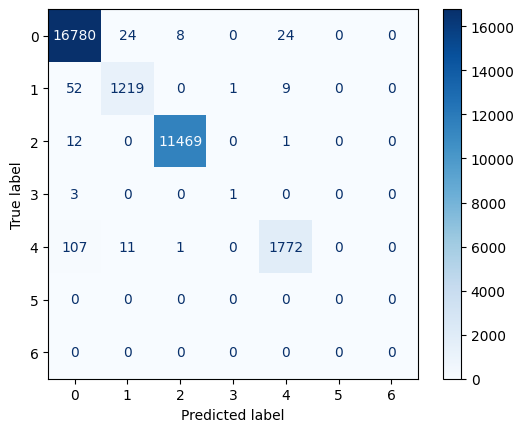

In [19]:
# Global configuration
from tensorflow.keras.optimizers import Adam, SGD

NUMOFCLIENTS = 10 # number of clients (particles)
EPOCHS = 30  # number of total iterations
CLIENT_EPOCHS = 5  # number of each client's iterations
BATCH_SIZE = 256 # Size of batches to train on
ACC = 0.3
LOCAL_ACC = 0.7
GLOBAL_ACC = 1.4
DROP_RATE = 0
SELECT_CLIENTS = 1
# Model configuration
# LOSS = 'binary_crossentropy'
LOSS = 'sparse_categorical_crossentropy'
NUMOFCLASSES = 7
lr = 0.00001
# lr = 0.0001
OPTIMIZER = Adam(learning_rate=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_FedAvg_10Clients_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = Model(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

import numpy as np

def client_data_config(x_train, y_train):
    num_clients = NUMOFCLIENTS
    num_samples = x_train.shape[0]
    num_per_client = num_samples // num_clients

    # Generate a random permutation of indices
    indices = np.random.permutation(num_samples)

    # Split indices into chunks for each client
    client_indices = np.array_split(indices, num_clients)

    # Prepare client data
    client_data = []
    data_distributions = []

    for i, idxs in enumerate(client_indices):
        new_x_train = x_train[idxs]
        new_y_train = y_train[idxs]

        client_data.append((new_x_train, new_y_train))

        # Record the data distribution for the client
        class_counts = np.bincount(new_y_train)
        class_distribution = {cls: count for cls, count in enumerate(class_counts) if count > 0}

        data_distribution = {
            'client_index': i,
            'num_samples': len(idxs),
            'classes_distribution': class_distribution
        }
        data_distributions.append(data_distribution)

    # Print the data distribution for each client
    for dist in data_distributions:
        print(f"Client {dist['client_index']}:")
        print(f"  Number of samples: {dist['num_samples']}")
        print(f"  Class distribution: {dist['classes_distribution']}")
        print()

    return client_data

def fedAVG(server_weight):
    avg_weight = [np.zeros_like(w) for w in server_weight[0]]  # Initialize with the same structure as the first set of weights

    for client_weights in server_weight:
        for i, w in enumerate(client_weights):
            avg_weight[i] += w

    avg_weight = [w / len(server_weight) for w in avg_weight]  # Compute the average

    return avg_weight

def client_update(index, client, now_epoch, avg_weight):
    print("client {}/{} fitting".format(index + 1, int(NUMOFCLIENTS * SELECT_CLIENTS)))

    optimizer = tf.keras.optimizers.Adam()
    client.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])
    if now_epoch != 0:
        client.set_weights(avg_weight)

    client.fit(client_data[index][0], client_data[index][1],
        epochs=CLIENT_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_split=0.2,
    )

    return client

if __name__ == "__main__":

    x_train = X_train_images
    y_train = Y_train
    x_test = X_test_images
    y_test = Y_test_test

    train_data_shape = (x_train[0].shape[1],)
    print("Shape of a single data point:", train_data_shape)
    client_data = client_data_config(x_train, y_train)

    server_model = init_model(train_data_shape=train_data_shape)

    fl_model = []
    for i in range(NUMOFCLIENTS):  # Keys are now starting from 0
        optimizer = Adam(learning_rate=lr)
        fl_model.append(init_model(train_data_shape=train_data_shape,))

    avg_weight = [np.zeros_like(w) for w in server_model.get_weights()]

    server_evaluate_acc = []

    for epoch in range(EPOCHS):
        server_weight = []

        selected_num = int(max(NUMOFCLIENTS * SELECT_CLIENTS, 1))
        split_data_index = []
        while len(split_data_index) < selected_num:
            item = random.choice(range(len(fl_model)))
            if item not in split_data_index:
                split_data_index.append(item)
        split_data_index.sort()
        selected_model = [fl_model[k] for k in split_data_index]

        for index, client in enumerate(selected_model):
            recv_model = client_update(index, client, epoch, avg_weight)

            rand = random.randint(0, 99)
            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_weight.append(copy.deepcopy(recv_model.get_weights()))

        avg_weight = fedAVG(server_weight)

        server_model.set_weights(avg_weight)
        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedAvg_iid_NSLKDD", server_evaluate_acc)

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(server_model.predict(x_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUMOFCLASSES))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUMOFCLASSES)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

'''Confusion Matrix FedAvg_iid_NSLKDD:
[[16780    24     8     0    24     0     0]
 [   52  1219     0     1     9     0     0]
 [   12     0 11469     0     1     0     0]
 [    3     0     0     1     0     0     0]
 [  107    11     1     0  1772     0     0]
 [    0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0]]'''